In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from evalutils import *
from lccv import lccv
from tqdm.notebook import tqdm

# Reading in Results and Checking Completeness

In [105]:
dfResults = pd.read_csv("results.csv", delimiter=";")
dfResults

,experiment_id,openmlid,algorithm,timeout,numpipelines,prob_dp,prob_fp,seed,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,validationscores,runtime,exception,time_end
0,1,1485,5cv,300,200,0.5,0.5,0,4,16000,2021-08-18 22:04:58,node02-015,oculus-8602686-92,2021-08-20 01:38:48,"[('data-pre-processor', RobustScaler(copy=Fals...",0.1375,"[0.1346,0.1365,0.1346,0.1692,0.1481,0.1135,0.1...",14827.0,NaN,2021-08-20 08:50:48
1,2,1485,5cv,300,200,0.5,0.5,1,4,16000,2021-08-18 22:04:58,node02-027,oculus-8602174-5,2021-08-19 00:14:30,"[('feature-pre-processor', FeatureAgglomeratio...",0.1469,"[0.1615,0.1442,0.1308,0.1788,0.1635,0.1231,0.1...",13521.0,NaN,2021-08-19 04:16:57
2,3,1485,10cv,300,200,0.5,0.5,0,4,16000,2021-08-18 22:04:58,node08-019,oculus-8602174-140,2021-08-19 03:02:37,"[('data-pre-processor', RobustScaler(copy=Fals...",0.1308,"[0.1385,0.1115,0.1115,0.1769,0.1654,0.1154,0.1...",30755.0,NaN,2021-08-19 15:04:17
3,4,1590,5cv,300,200,0.5,0.5,0,4,16000,2021-08-18 22:04:58,node01-014,oculus-8602174-53,2021-08-19 01:37:23,"[('predictor', SGDClassifier(alpha=0.000154513...",0.1588,"[0.1591,0.1575,0.1576,0.1582,0.1572,0.1589,0.1...",14564.0,NaN,2021-08-19 05:42:14
4,5,1485,10cv,300,200,0.5,0.5,1,4,16000,2021-08-18 22:04:58,node05-022,oculus-8602174-111,2021-08-19 00:41:31,"[('predictor', HistGradientBoostingClassifier(...",0.1480,"[0.1538,0.1269,0.1346,0.1885,0.1577,0.1308,0.1...",30767.0,NaN,2021-08-19 12:24:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2676,31,90lccv-flex,300,200,0.5,0.5,7,4,16000,2021-08-18 22:04:58,node04-040,oculus-8621318-1052,2021-08-22 16:26:45,"[('feature-pre-processor', RBFSampler(gamma=4....",0.2544,"[0.28,0.21,0.21,0.31,0.26,0.3,0.21,0.17,0.31,0...",2327.0,NaN,2021-08-22 17:31:06
2676,2677,40975,90lccv-flex,300,200,0.5,0.5,9,4,16000,2021-08-18 22:04:58,node05-038,oculus-8621318-1445,2021-08-22 16:47:26,"[('data-pre-processor', Normalizer()), ('predi...",0.0004,"[0.0,0.0,0.0,0.0,0.0,0.0116,0.0,0.0,0.0,0.0,0....",5295.0,NaN,2021-08-22 18:19:51
2677,2678,31,80lccv-flex,300,200,0.5,0.5,9,4,16000,2021-08-18 22:04:58,node06-001,oculus-8621318-1392,2021-08-22 15:51:29,"[('data-pre-processor', QuantileTransformer(n_...",0.2597,"[0.24,0.22,0.215,0.29,0.275,0.255,0.225,0.245,...",1443.0,NaN,2021-08-22 16:15:58
2678,2679,31,90lccv-flex,300,200,0.5,0.5,8,4,16000,2021-08-18 22:04:58,node05-044,oculus-8621318-1428,2021-08-22 16:09:48,"[('feature-pre-processor', SelectPercentile(pe...",0.2666,"[0.36,0.23,0.25,0.26,0.3,0.29,0.23,0.23,0.29,0...",1698.0,NaN,2021-08-22 16:39:44


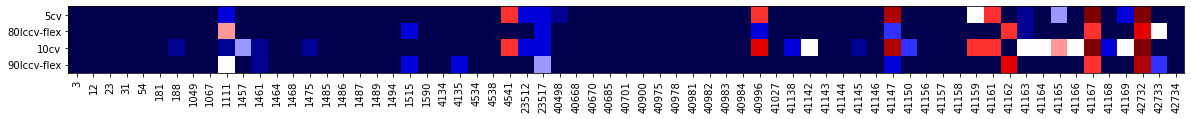

In [130]:
def plot_result_availability(dfResults):
    algorithms = ["5cv", "80lccv-flex", "10cv", "90lccv-flex"]
    datasets = sorted(list(pd.unique(dfResults["openmlid"])))
    Z = np.zeros((len(algorithms), len(datasets)))
    for i, algorithm in enumerate(algorithms):
        for j, openmlid in enumerate(datasets):
            dfProjected = dfResults[(dfResults["algorithm"] == algorithm) & (dfResults["openmlid"] == openmlid)]
            dfProjected = dfProjected[dfProjected["exception"].isna()]
            Z[i,j] = len(dfProjected)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.imshow(-Z, cmap="seismic", vmax=0, vmin=-10)
    ax.set_xticks(range(len(datasets)))
    ax.set_xticklabels(datasets, rotation=90)
    ax.set_yticks(range(len(algorithms)))
    ax.set_yticklabels(algorithms)
    plt.show()
    
plot_result_availability(dfResults)

In [134]:
dfResults80 = dfResults[dfResults["algorithm"].isin(["80lccv-flex", "5cv"]) & (dfResults["exception"].isna())]
dfResults90 = dfResults[dfResults["algorithm"].isin(["90lccv-flex", "10cv"]) & (dfResults["exception"].isna())]

In [135]:
dfResults80.query("algorithm == '5cv' and openmlid == 1111")

,experiment_id,openmlid,algorithm,timeout,numpipelines,prob_dp,prob_fp,seed,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,validationscores,runtime,exception,time_end
465,466,1111,5cv,300,200,0.5,0.5,0,4,16000,2021-08-18 22:04:58,node03-034,oculus-8602174-431,2021-08-19 06:41:54,"[('data-pre-processor', QuantileTransformer(n_...",0.0176,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",33659.0,NaN,2021-08-19 19:43:23
479,480,1111,5cv,300,200,0.5,0.5,1,4,16000,2021-08-18 22:04:58,node06-004,oculus-8602686-77,2021-08-19 09:18:02,"[('data-pre-processor', Normalizer()), ('featu...",0.0177,"[0.0173,0.0194,0.0172,0.0171,0.0176,0.0185,0.0...",34125.0,NaN,2021-08-19 19:02:16
497,498,1111,5cv,300,200,0.5,0.5,2,4,16000,2021-08-18 22:04:58,node08-001,oculus-8602686-61,2021-08-19 09:18:59,"[('feature-pre-processor', Nystroem(gamma=0.27...",0.0176,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",33500.0,NaN,2021-08-19 22:20:40
516,517,1111,5cv,300,200,0.5,0.5,3,4,16000,2021-08-18 22:04:58,node02-027,oculus-8602174-438,2021-08-19 08:01:48,"[('predictor', RandomForestClassifier(max_feat...",0.0176,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",32545.0,NaN,2021-08-19 21:29:38
1814,1815,1111,5cv,300,200,0.5,0.5,6,4,16000,2021-08-18 22:04:58,node07-006,oculus-8621318-307,2021-08-21 12:52:53,"[('feature-pre-processor', SelectPercentile(pe...",0.0250,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",33286.0,NaN,2021-08-22 04:52:24
1839,1840,1111,5cv,300,200,0.5,0.5,7,4,16000,2021-08-18 22:04:58,node07-033,oculus-8621318-493,2021-08-21 13:54:21,"[('data-pre-processor', QuantileTransformer(n_...",0.0176,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",25127.0,NaN,2021-08-22 03:45:22
1859,1860,1111,5cv,300,200,0.5,0.5,8,4,16000,2021-08-18 22:04:58,node07-012,oculus-8621318-637,2021-08-21 14:32:57,"[('feature-pre-processor', Nystroem(coef0=-0.2...",0.0176,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",14291.0,NaN,2021-08-22 03:22:30
1887,1888,1111,5cv,300,200,0.5,0.5,9,4,16000,2021-08-18 22:04:58,node08-042,oculus-8621318-650,2021-08-21 14:19:05,"[('data-pre-processor', QuantileTransformer(n_...",0.0176,"[0.0167,0.0173,0.0184,0.0189,0.0172,0.0174,0.0...",24055.0,NaN,2021-08-22 05:03:12


# How many cases of performance loss

In [331]:
def create_deviation_list(dfResults):
    
    # absolute runtimes
    algorithms = ["5cv", "80lccv-flex", "10cv", "90lccv-flex"]
    algorithm_names = {"5cv": "5CV", "80lccv-flex": "80LCCV", "10cv": "10CV", "90lccv-flex": "90LCCV"}
    datasets = pd.unique(dfResults["openmlid"])
    
    # pairwise comparisons
    deviations_time = []
    deviations_error = []
    for algo_pair in [("5cv", "80lccv-flex"), ("10cv", "90lccv-flex")]:
        reductions_abs_pair = []
        reductions_rel_pair = []
        performance_diffs_pair = []
        for key, dfForKey in dfResults[dfResults["algorithm"].isin(list(algo_pair))].groupby(["openmlid", "seed"]):
            if len(dfForKey) == 2:
                
                # compute comparison
                row_baseline = dfForKey[dfForKey["algorithm"] == algo_pair[0]]
                row_lccv = dfForKey[dfForKey["algorithm"] == algo_pair[1]]
                runtime_baseline = row_baseline["runtime"].values
                runtime_lccv = row_lccv["runtime"].values
                score_baseline = row_baseline["errorrate"].values
                score_lccv = row_lccv["errorrate"].values
                
                # check undesired cases
                if runtime_baseline < runtime_lccv:
                    deviations_time.append([key[0], key[1], row_baseline["algorithm"].values[0], row_lccv["algorithm"].values[0], row_baseline["runtime"].values[0], row_baseline["executor"].values[0], row_lccv["runtime"].values[0], row_lccv["executor"].values[0]])
                if score_baseline < score_lccv:
                    deviations_error.append([key[0], key[1], row_baseline["algorithm"].values[0], row_lccv["algorithm"].values[0], row_baseline["errorrate"].values[0], row_baseline["executor"].values[0], row_lccv["errorrate"].values[0], row_lccv["executor"].values[0]])
            
    cols_time = ["openmlid", "seed", "baseline", "lccv", "runtime baseline", "logfile baseline", "runtime lccv", "logfile lccv"]
    cols_err = ["openmlid", "seed", "baseline", "lccv", "error rate baseline", "logfile baseline", "error rate lccv", "logfile lccv"]
    return (pd.DataFrame(deviations_time, columns=cols_time), pd.DataFrame(deviations_error, columns=cols_err))

            
dfDeviationsTime, dfDeviationsScore = create_deviation_list(dfResults)
dfDeviationsScore = dfDeviationsScore[dfDeviationsScore["error rate baseline"] < dfDeviationsScore["error rate lccv"] - 0.005]

In [346]:
dfDeviationsScore.query("openmlid == 1067")

,openmlid,seed,baseline,lccv,error rate baseline,logfile baseline,error rate lccv,logfile lccv
53,1067,3,5cv,80lccv-flex,0.1380,oculus-8609764-238,0.1468,oculus-8609764-358
55,1067,7,5cv,80lccv-flex,0.1375,oculus-8621318-1250,0.1432,oculus-8621318-1384
56,1067,8,5cv,80lccv-flex,0.1367,oculus-8621318-1046,0.1424,oculus-8621318-1054
378,1067,0,10cv,90lccv-flex,0.1396,oculus-8609764-303,0.1466,oculus-8609764-195
379,1067,1,10cv,90lccv-flex,0.1377,oculus-8609764-308,0.1466,oculus-8609764-231
380,1067,3,10cv,90lccv-flex,0.1374,oculus-8609764-327,0.1466,oculus-8609764-274
381,1067,4,10cv,90lccv-flex,0.1376,oculus-8609764-283,0.1462,oculus-8609764-372
382,1067,5,10cv,90lccv-flex,0.1357,oculus-8621318-1073,0.1468,oculus-8621318-1387
383,1067,6,10cv,90lccv-flex,0.1409,oculus-8621318-1266,0.1488,oculus-8621318-1447
384,1067,7,10cv,90lccv-flex,0.1370,oculus-8621318-1209,0.1457,oculus-8621318-1051


In [349]:
for (openmlid, baseline), dfDeviationsScoreOnDataset in dfDeviationsScore.groupby(["openmlid", "baseline"]):
    if np.mean(dfDeviationsScoreOnDataset["error rate lccv"] - dfDeviationsScoreOnDataset["error rate baseline"]) > 0.02:
        print(f"{openmlid} ({baseline}): {len(dfDeviationsScoreOnDataset)}")

23 (10cv): 4
54 (5cv): 5
181 (10cv): 5
188 (10cv): 6
188 (5cv): 4
1111 (5cv): 1
1457 (10cv): 1
1457 (5cv): 4
1464 (10cv): 7
40498 (10cv): 4
40668 (5cv): 6
40685 (10cv): 1
41027 (5cv): 3
41147 (5cv): 1
41157 (10cv): 4
41157 (5cv): 7
41159 (5cv): 2
41164 (10cv): 4
41164 (5cv): 7
41166 (5cv): 6
41168 (5cv): 3


# Comparison Plots

In [136]:
datasets_dense = [1485, 1515, 1475, 1468, 1489, 23512, 23517, 40981, 40982, 40983, 40984, 40701, 40685, 40900,  1111, 40498, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41142, 41143, 41144, 41145, 41146, 41150, 41156, 41157, 41158,  41159, 41138, 54, 181, 188, 1461, 1494, 1464, 12, 23, 3, 1487, 40668, 1067, 1049, 40975, 31]
#1457
datasets_sparse = [1590, 1486, 4534, 4541, 4538, 4134, 4135, 40978, 40996, 41027, 40670, 42732, 42733, 42734, 41147]
datasets = datasets_dense + datasets_sparse

Median of absolute reduction is 53.216296296296285 for 80LCCV and 165.34833333333336 for 90LCCV
Mean of absolute reduction is 91.41528612128612 for 80LCCV and 165.35928907203908 for 90LCCV
Median of relative reduction is 0.7125547108961069 for 80LCCV and 0.6300976811644853 for 90LCCV
Mean of relative reduction is 0.8283242882733642 for 80LCCV and 0.6552558567377196 for 90LCCV
78.46% of the observed error rates of lccv deviate by at most 0.005 from the 5CV baseline.
73.85% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
84.62% of the observed error rates of lccv deviate by at most 0.01 from the 5CV baseline.
87.69% of the observed error rates of lccv deviate by at most 0.01 from the 10CV baseline.
92.31% of the observed error rates of lccv deviate by at most 0.015 from the 5CV baseline.
90.77% of the observed error rates of lccv deviate by at most 0.015 from the 10CV baseline.


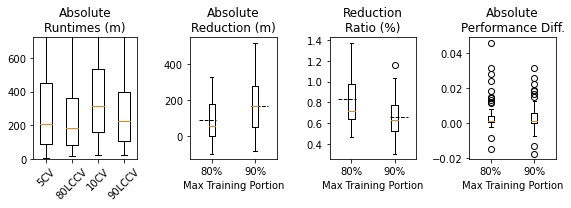

In [345]:
def create_summary_scatterplot(dfResults, suffix):
    fig, ax = plt.subplots(figsize=(15, 15))
    i = 0
    for openmlid, dfDataset in dfResults.groupby("openmlid"):
        dfLCCV = dfDataset[dfDataset["algorithm"].isin(["80lccv-flex", "90lccv-flex"])]
        dfBaseline = dfDataset[dfDataset["algorithm"].isin(["5cv", "10cv"])]
        lccv = [np.mean(dfLCCV["errorrate"]), np.mean(dfLCCV["runtime"])]
        mccv = [np.mean(dfBaseline["errorrate"]), np.mean(dfBaseline["runtime"])]
        mccv_has_result = not all(np.isnan(mccv))
        
        lccv_name = list(pd.unique(dfLCCV["algorithm"]))[0][:-5].upper()
        base_name = "5CV" if lccv_name == "80LCCV" else "10CV"
        
        ax.scatter(lccv[1], lccv[0], color="C0", label=lccv_name if i == 0 else None)
        if mccv_has_result:
            ax.scatter(mccv[1], mccv[0], color="C1", label=base_name if i == 0 else None)
            ax.plot([lccv[1], mccv[1]], [lccv[0], mccv[0]], color="green" if lccv[1] < mccv[1] else "red", linestyle="--", linewidth=1)
            ax.text((lccv[1] + mccv[1]) / 2.1, (lccv[0] + mccv[0]) / 2, int(openmlid))
            avg_time_saving = int((mccv[1] - lccv[1]) / 60)
            avg_reduction = np.round((1 - lccv[1] / mccv[1]) * 100)
            ax.text((lccv[1] + mccv[1]) / 2.5, (lccv[0] + mccv[0]) / 2 - 0.01, str(avg_time_saving) + "m (" + str(avg_reduction) + "%)")
        else:
            ax.text(lccv[1], lccv[0], int(openmlid))
        i += 1
    ax.set_xlabel("Runtime (s)")
    ax.set_ylabel("Error Rate")
    for y in np.linspace(0, 0.7, 71):
        ax.axhline(y, alpha=0.05, color="black")
    ax.axvline(1800, linestyle="--", color="black", linewidth=1)
    ax.axvline(3600, linestyle="--", color="black", linewidth=1)
    ax.axvline(36000, linestyle="--", color="black", linewidth=1)
    ax.set_ylim([0, 0.7])
    ax.set_xlim([5 * 10**2, 10**5])
    ax.set_xscale("log")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"plots/results-randomsearch-scatter-{suffix}.pdf")
    plt.show()
    

def create_summary_boxplots(dfResults):
    
    fig, ax = plt.subplots(1, 4, figsize=(8, 3), gridspec_kw={'width_ratios': [1.2, 1, 1, 1]})
    
    # absolute runtimes
    algorithms = ["5cv", "80lccv-flex", "10cv", "90lccv-flex"]
    algorithm_names = {"5cv": "5CV", "80lccv-flex": "80LCCV", "10cv": "10CV", "90lccv-flex": "90LCCV"}
    datasets = pd.unique(dfResults["openmlid"])
    ax[0].boxplot([dfResults[dfResults["algorithm"] == a]["runtime"].values / 60 for a in algorithms])
    ax[0].set_title("Absolute\nRuntimes (m)")
    ax[0].set_ylim([0, 60 * 12])
    ax[0].set_xticks(range(1, 5))
    ax[0].set_xticklabels([algorithm_names[a] for a in algorithms], rotation=45)
    
    # pairwise comparisons
    reductions_abs = []
    reductions_rel = []
    performance_diffs = []
    for algo_pair in [("5cv", "80lccv-flex"), ("10cv", "90lccv-flex")]:
        reductions_abs_pair = []
        reductions_rel_pair = []
        performance_diffs_pair = []
        for openmlid, dfDataset in dfResults[dfResults["algorithm"].isin(list(algo_pair))].groupby("openmlid"):
            runtime_baseline = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[0]]["runtime"])
            runtime_lccv = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[1]]["runtime"])
            score_baseline = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[0]]["errorrate"])
            score_lccv = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[1]]["errorrate"])
            if not np.isnan(runtime_baseline):
                reductions_abs_pair.append(runtime_baseline - runtime_lccv)
                reductions_rel_pair.append(runtime_lccv / runtime_baseline)
                performance_diffs_pair.append(score_lccv - score_baseline)
        reductions_abs.append(reductions_abs_pair)
        reductions_rel.append(reductions_rel_pair)
        performance_diffs.append(performance_diffs_pair)
    for i, (name, reductions) in enumerate([("Absolute\nReduction (m)", reductions_abs), ("Reduction\nRatio (%)", reductions_rel)], 1):
        reductions = np.array(reductions).T
        if i == 1:
            reductions /= 60
            print(f"Median of absolute reduction is {np.median(reductions[:,0])} for 80LCCV and {np.median(reductions[:,1])} for 90LCCV")
            print(f"Mean of absolute reduction is {np.mean(reductions[:,0])} for 80LCCV and {np.mean(reductions[:,1])} for 90LCCV")
        else:
            print(f"Median of relative reduction is {np.median(reductions[:,0])} for 80LCCV and {np.median(reductions[:,1])} for 90LCCV")
            print(f"Mean of relative reduction is {np.mean(reductions[:,0])} for 80LCCV and {np.mean(reductions[:,1])} for 90LCCV")
        ax[i].boxplot(reductions)
        ax[i].set_title(name)
        ax[i].axhline(np.mean(reductions[:,0]), linestyle="--", linewidth=1, color="black", xmin=0.1, xmax=.3)
        ax[i].axhline(np.mean(reductions[:,1]), linestyle="--", linewidth=1, color="black", xmin=.7, xmax=.9)
    
    # deviations in performance
    ax[3].boxplot(performance_diffs)
    ax[3].set_title("Absolute\nPerformance Diff.")
    for threshold in [0.005, 0.01, 0.015]:
        for i, diffs in enumerate(performance_diffs):        
            print(f"{np.round(100 * np.count_nonzero(np.array(diffs) <= threshold) / len(diffs), 2)}% of the observed error rates of lccv deviate by at most {threshold} from the {'5CV' if i == 0 else '10CV'} baseline.")
    
    # set x labels for comparative plots
    for i in range(1, 4):
        ax[i].set_xticks(range(1, 3))
        ax[i].set_xticklabels(["80%", "90%"])
        ax[i].set_xlabel("Max Training Portion")
    
    
    fig.tight_layout()
    fig.savefig("plots/results-randomsearch-boxplots.pdf")
    plt.show()
    
create_summary_boxplots(dfResults[dfResults["exception"].isna()])

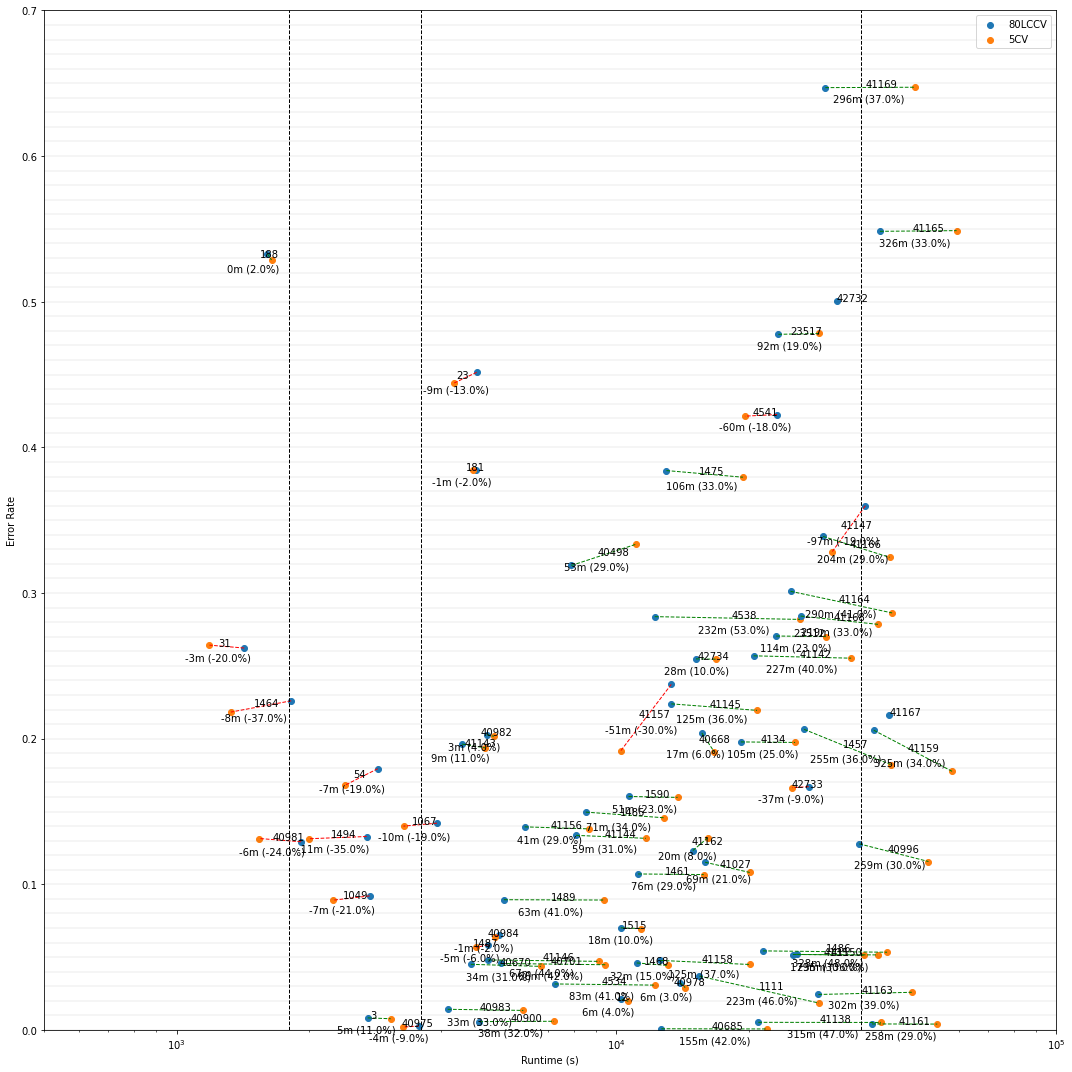

In [297]:
create_summary_scatterplot(dfResults80, "80")

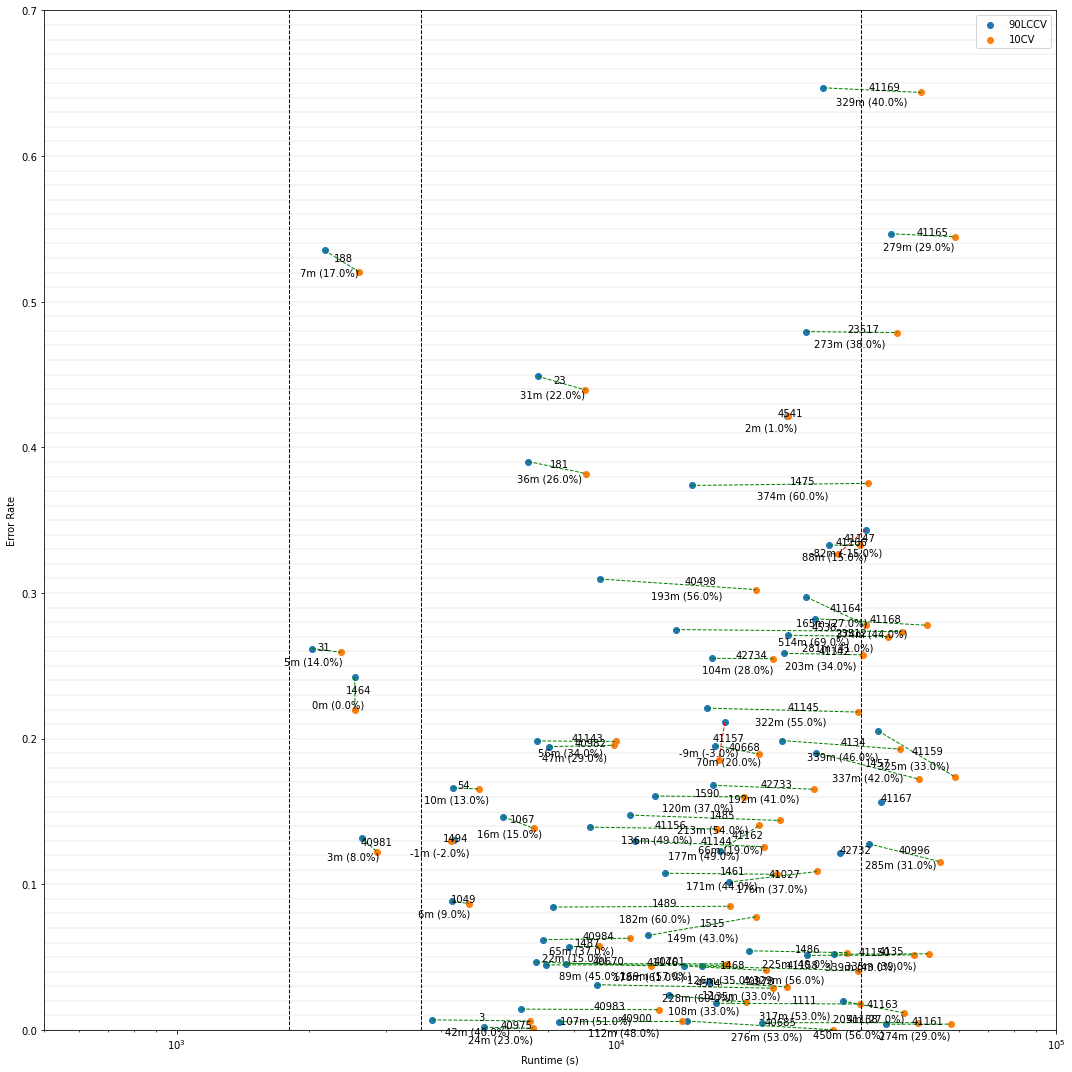

In [298]:
create_summary_scatterplot(dfResults90, "90")

In [93]:
def visualize_size_error_relation(df):
    dev_size_relations = []
    for openmlid in tqdm(pd.unique(df["openmlid"])):
        openmlid = int(openmlid)
        vals = df[df["openmlid"] == openmlid][["avg_error_10cv", "avg_error_lccv"]]
        if len(vals) > 0:
            dataset = openml.datasets.get_dataset(openmlid)
            dfDataset = dataset.get_data()[0]
            diff = vals.values[0][1] - vals.values[0][0]
            dev_size_relations.append((openmlid, dfDataset.shape[0], diff))
            if diff > 0.01:
                print(openmlid, dfDataset.shape, np.round(diff, 3))
    fig, ax = plt.subplots()
    ax.scatter([t[1] for t in dev_size_relations], [t[2] for t in dev_size_relations])
    ax.axhline(0, color="black", linewidth=1)
    ax.axhline(0.01, color="black", linewidth=1)
    ax.axvline(2000, color="black", linewidth=1)
    ax.set_xscale("log")
    ax.set_xlabel("Dataset Size")

54 (846, 19) 0.011
1111 (50000, 231) 0.025
1457 (1500, 10001) 0.024
40668 (67557, 43) 0.013
41147 (425240, 79) 0.049
41157 (100, 10001) 0.045
41159 (20000, 4297) 0.017
41164 (8237, 801) 0.015
41166 (58310, 181) 0.014



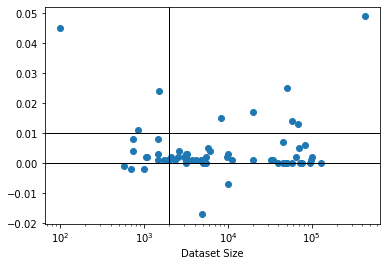

In [102]:
visualize_size_error_relation(dfResults80)

23 (1473, 10) 0.01
188 (736, 20) 0.016
1457 (1500, 10001) 0.012
1464 (748, 5) 0.022
40981 (690, 15) 0.01
41157 (100, 10001) 0.025
41164 (8237, 801) 0.019



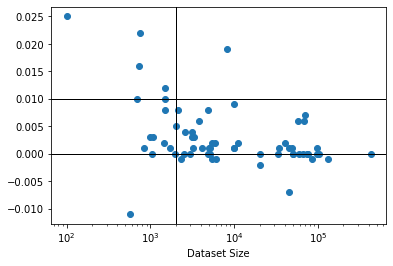

In [103]:
visualize_size_error_relation(dfResults90)

In [162]:
def get_latex_table(dfResults):
    rows = []
    for openmlid in tqdm(sorted(pd.unique(dfResults["openmlid"]))):
        df_ds = dfResults[dfResults["openmlid"] == openmlid]
        mask_lccv = df_ds["algorithm"].isin(["80lccv-flex", "90lccv-flex"])
        df_lccv = df_ds[mask_lccv]
        df_10cv = df_ds[~mask_lccv]
        
        performance_lccv = str(np.round(np.mean(df_lccv["errorrate"]), 2)) + "$\pm$" + '{:04.2f}'.format(np.std(df_lccv["errorrate"]), 2)
        runtime_lccv = str(int(np.round(np.mean(df_lccv["runtime"])))) + "$\pm$" + str(int(np.round(np.std(df_lccv["runtime"]))))
        
        # get results for baseline
        if len(df_10cv) > 0:
            performance_10cv = str(np.round(np.mean(df_10cv["errorrate"]), 2)) + "$\pm$" + '{:04.2f}'.format(np.std(df_10cv["errorrate"]), 2)
            runtime_10cv = str(int(np.round(np.mean(df_10cv["runtime"])))) + "$\pm$" + str(int(np.round(np.std(df_10cv["runtime"]))))
        else:
            performance_10cv, runtime_10cv = np.nan, 86400
        
        rows.append([openmlid, performance_lccv, runtime_lccv, performance_10cv, runtime_10cv])
    columns = ["openmlid", "LCCV Performance", "LCCV Runtime", "Baseline CV Perf", "Baseline CV Runtime"]
    return pd.DataFrame(rows, columns=columns).to_latex(index=False, escape=False)

print(get_latex_table(dfResults80))


\begin{tabular}{rllll}
\toprule
 openmlid & LCCV Performance &   LCCV Runtime & Baseline CV Perf & Baseline CV Runtime \\
\midrule
        3 &    0.01$\pm$0.00 &   2719$\pm$649 &    0.01$\pm$0.00 &        3068$\pm$765 \\
       12 &    0.02$\pm$0.00 &  10266$\pm$638 &    0.02$\pm$0.00 &      10639$\pm$1521 \\
       23 &    0.45$\pm$0.01 &   4812$\pm$744 &    0.44$\pm$0.00 &        4268$\pm$615 \\
       31 &    0.26$\pm$0.00 &   1425$\pm$432 &    0.26$\pm$0.01 &        1188$\pm$362 \\
       54 &    0.18$\pm$0.02 &   2867$\pm$513 &    0.17$\pm$0.01 &        2412$\pm$639 \\
      181 &    0.38$\pm$0.01 &   4805$\pm$750 &    0.38$\pm$0.00 &       4730$\pm$1205 \\
      188 &    0.53$\pm$0.01 &   1609$\pm$413 &    0.53$\pm$0.01 &        1644$\pm$559 \\
     1049 &    0.09$\pm$0.00 &   2746$\pm$489 &    0.09$\pm$0.00 &        2267$\pm$392 \\
     1067 &    0.14$\pm$0.00 &   3910$\pm$626 &    0.14$\pm$0.00 &        3280$\pm$675 \\
     1111 &    0.04$\pm$0.03 & 15443$\pm$1488 &    0.02$\p